# Importing Libraries and Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Dense, Dropout, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Loading the Dataset

In [6]:
tweets = pd.read_csv('Tweets.csv')

In [7]:
tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Basic EDA

In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
tweets.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [10]:
tweets.dropna(inplace=True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


* null values have been removed

# **Text Preprocessing**

# Regular expression and creating words tokens

In [11]:
text_tokenized = []
for i,sentence in enumerate(tweets['text']):
  tokens = re.sub('[^a-zA-Z]',' ',sentence)            # using regular expression
  tokens = tokens.lower()
  tokens = tokens.split()
  text_tokenized.append(tokens)

In [12]:
text_tokenized[0:2]

[['i', 'd', 'have', 'responded', 'if', 'i', 'were', 'going'],
 ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']]

# Stemming

In [13]:
porter = PorterStemmer()

In [14]:
stemmed_text = []
for i,stems in enumerate(text_tokenized):
    stemming = [porter.stem(j) for j in stems]
    stemmed_text.append(stemming)

In [15]:
stemmed_text[:2]

[['i', 'd', 'have', 'respond', 'if', 'i', 'were', 'go'],
 ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']]

# StopWords removal from the stemmed text

In [16]:
stop_words = set(stopwords.words('english'))
cleaned = []
for i,words in enumerate(stemmed_text):
    clean = [j for j in words if j.lower() not in stop_words]
    cleaned.append(clean)

In [17]:
cleaned[:2]

[['respond', 'go'], ['sooo', 'sad', 'miss', 'san', 'diego']]

# Now Creating Embeddings of the clean text

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned)

In [19]:
cleaned[:2]

[['respond', 'go'], ['sooo', 'sad', 'miss', 'san', 'diego']]

In [20]:
sequences = tokenizer.texts_to_sequences(cleaned)

In [21]:
sequences[:2]

[[1303, 2], [325, 55, 21, 1167, 1988]]

# creating padded_Embeddings

In [22]:
pad_len = len(max(sequences))
print(f"Padding width : {pad_len}")

Padding width : 10


In [23]:
padded_sequences = sequence.pad_sequences(sequences, maxlen = pad_len)
padded_sequences[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0, 1303,    2],
       [   0,    0,    0,    0,    0,  325,   55,   21, 1167, 1988]],
      dtype=int32)

* as now we have created padded_embedding let's create a feature in dataset (tweets)

In [24]:
# converting the sentiments into the numerical format
Labels = le.fit_transform(tweets['sentiment'])

In [25]:
tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Independent and dependent

In [26]:
X = padded_sequences
Y = Labels

X.shape, Y.shape

((27480, 10), (27480,))

# Splitting into Training and Testing Set

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20610, 10), (20610,), (6870, 10), (6870,))

# Model Development

In [28]:
model = Sequential()
model.add(layers.Embedding(input_dim=x_train.shape[0],output_dim=64))
model.add(SpatialDropout1D(rate=0.40))
model.add(LSTM(128))
model.add(Dense(3,activation='softmax'))

In [29]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [30]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                               restore_best_weights=True)

learning_rate = keras.callbacks.ReduceLROnPlateau(factor=0.01,
                                                  patience=10)

In [31]:
history = model.fit(x_train,y_train,
                    batch_size=64,
                    validation_split=0.20,
                    epochs = 30,
                    verbose= 1,callbacks=[early_stopping,learning_rate] )

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4861 - loss: 0.9907 - val_accuracy: 0.6591 - val_loss: 0.7905 - learning_rate: 0.0010
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7287 - loss: 0.6558 - val_accuracy: 0.6761 - val_loss: 0.7736 - learning_rate: 0.0010
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8041 - loss: 0.5081 - val_accuracy: 0.6691 - val_loss: 0.8213 - learning_rate: 0.0010
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8436 - loss: 0.4152 - val_accuracy: 0.6611 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8767 - loss: 0.3479 - val_accuracy: 0.6497 - val_loss: 0.9613 - learning_rate: 0.0010
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8914 - loss: 0.3114 - val_accuracy: 0.6604 - val_loss: 1.0529 - learning_rate: 0.0010
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9114 - loss: 0.2530 -

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 64)         │     1,319,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 10, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,254,731 (16.23 MB)

 Trainable params: 1,418,243 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,836,488 (10.82 MB)

In [33]:
loss , accuracy = model.evaluate(x_test,y_test)
print(f"\nAccuracy : {accuracy:.4f}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6831 - loss: 0.7469

Accuracy : 0.6834


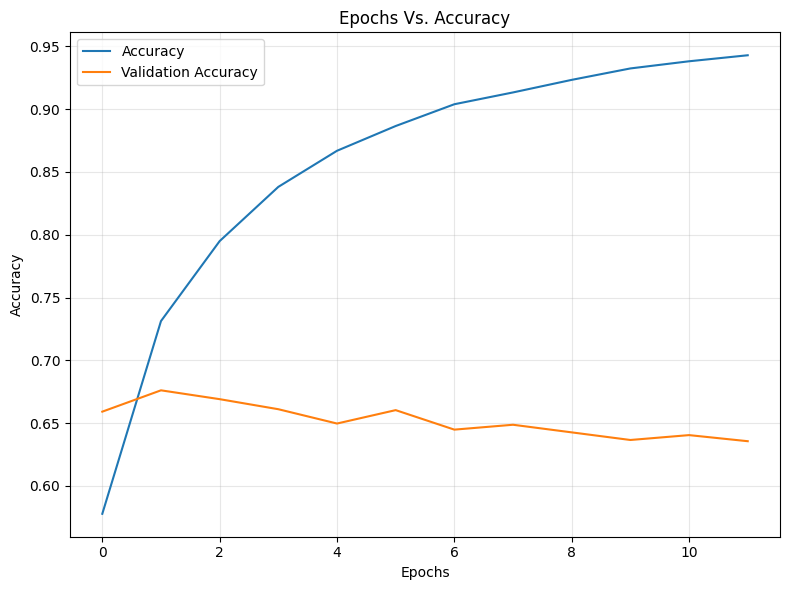

In [34]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs Vs. Accuracy")
plt.tight_layout()
plt.legend()
plt.grid(alpha=0.30)
plt.show()

In [35]:
predictions  = model.predict(x_test)
y_pred = [predicted.argmax() for predicted in predictions]
y_pred[:2]

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[np.int64(2), np.int64(1)]

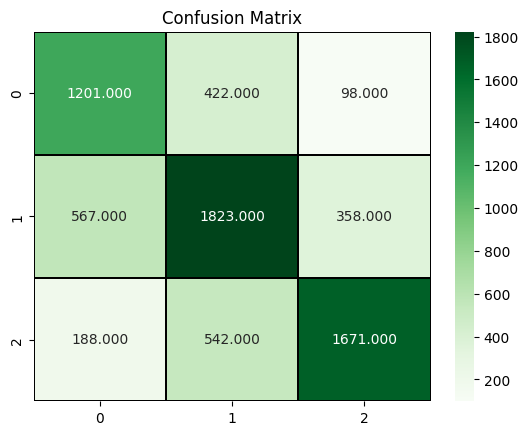

In [36]:
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, cmap='Greens', annot=True, fmt='.3f', linecolor='black', linewidths=0.03)
plt.title("Confusion Matrix")
plt.show()